# NLP with Disaster Tweets - Mini Project Report

## Problem & Data Description
This mini-project is based on the Kaggle competition Natural Language Processing with Disaster Tweets. The goal is to classify whether a given tweet is about a real disaster (label 1) or not (label 0). This is a binary text classification problem.

Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on the interaction between computers and human language. NLP involves tasks like sentiment analysis, topic detection, machine translation, and in this case, disaster tweet classification. It enables machines to understand and process natural language to derive meaning, insights, and classifications from textual data.

## Dataset Overview:
- Training Set: train.csv
    - Rows: 7,613 tweets
    - Columns:
 
        - id: Unique identifier for the tweet
        - keyword: Keyword from the tweet (may be missing)
        - location: Tweet location (may be missing)
        - text: Full tweet text
        - target: Binary label (1 = disaster, 0 = not disaster)

- Test Set: test.csv
    - Contains similar structure, but without the target column (to be predicted)

This dataset is suitable for learning real-world applications of NLP, especially in handling noisy, unstructured social media text.

### Importing Libraries
Here, we import essential Python libraries for data handling, visualization, preprocessing, model building, and evaluation. TensorFlow is used to construct and train deep learning models.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

### Loading the Dataset
We load the training and test datasets provided by the Kaggle competition using `pandas`. The datasets contain tweet texts and corresponding labels indicating whether a tweet is about a disaster or not.

In [34]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### Dataset Overview
We inspect the structure, column types, and null values in the training dataset to understand the data before preprocessing.

In [35]:
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  



## Exploratory Data Analysis (EDA)
We’ll inspect the class distribution and some text statistics.


### Class Distribution
We visualize the distribution of the target variable to check for class imbalance. This helps guide model evaluation strategy.

target
0    4342
1    3271
Name: count, dtype: int64


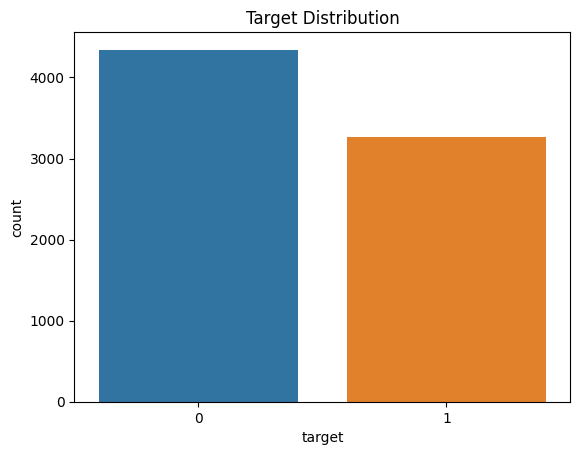

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


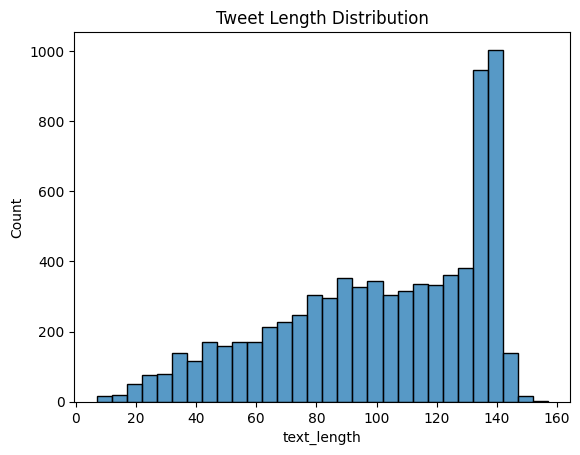

In [36]:
print(train_df["target"].value_counts())
sns.countplot(x="target", data=train_df)
plt.title("Target Distribution")
plt.show()

train_df["text_length"] = train_df["text"].apply(len)
sns.histplot(train_df["text_length"], bins=30)
plt.title("Tweet Length Distribution")
plt.show()


## Data Cleaning
We clean the tweets by lowercasing, removing URLs, punctuation, and extra spaces.


### Text Cleaning Function
A function to clean tweets by removing URLs, punctuation, and special characters. This helps standardize the text for NLP modeling.

In [37]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\\S+", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\\s+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["text"].apply(clean_text)
print(train_df["clean_text"][1])

forest fire near la ronge sask. canada


In [38]:
X = train_df["clean_text"]
y = train_df["target"]

## Train/Test Split

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Tokenization and Padding
We convert the cleaned text into sequences of integers using Keras Tokenizer, then pad them to ensure consistent input lengths for the neural network.

In [40]:
MAX_WORDS = 10000
MAX_LEN = 25
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

## Initial Model

For starters, I will be implementing a model with simple architecture.
As the optimizer, I will use the Adam optimizer, and compile the model using the Binary Cross Entropy loss function. 
The compilation settings will remain the same for my next model to have a good baseline for comparison.

In [41]:
simple = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00004)

simple.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
simple.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
simple_history = simple.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_val_pad, y_val))

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5325 - loss: 0.6914 - val_accuracy: 0.5758 - val_loss: 0.6834
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5620 - loss: 0.6828 - val_accuracy: 0.5758 - val_loss: 0.6782
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5698 - loss: 0.6770 - val_accuracy: 0.5791 - val_loss: 0.6734
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5831 - loss: 0.6695 - val_accuracy: 0.5949 - val_loss: 0.6658
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6134 - loss: 0.6572 - val_accuracy: 0.6277 - val_loss: 0.6521
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6747 - loss: 0.6355 - val_accuracy: 0.6671 - val_loss: 0.6297
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7341 - loss: 0.6011 - val_accuracy: 0.6973 - val_loss: 0.6012
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7784 - loss: 0.5576 - val_accuracy: 0.

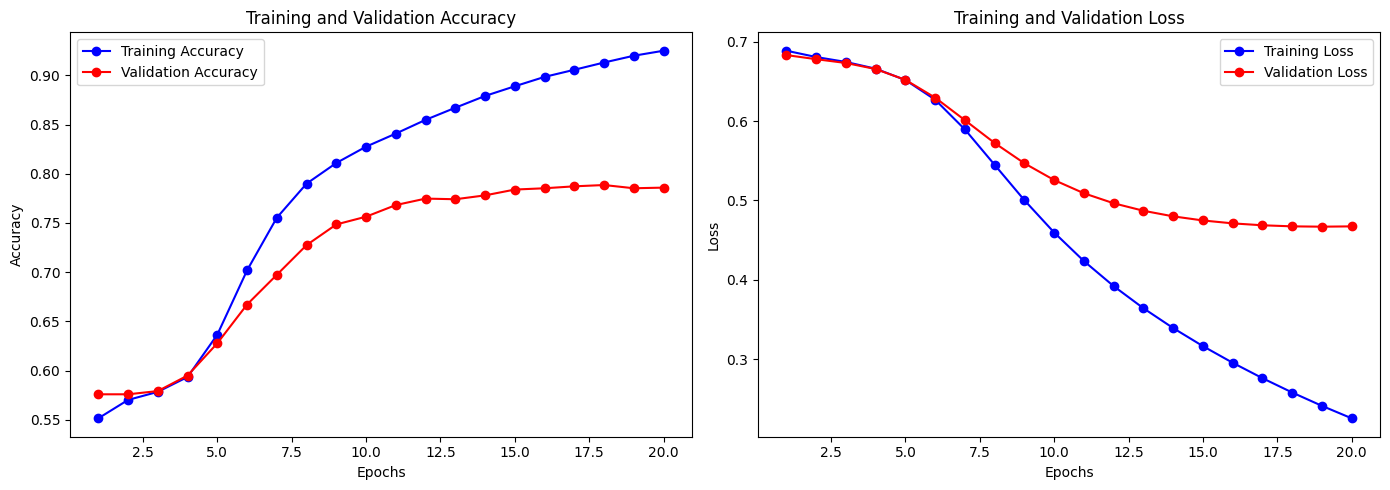

In [48]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(simple_history)


## Adding LSTM Layer
We tokenize and pad the sequences and build a Bidirectional LSTM model.


### Compiling the Model
The model is compiled using binary cross-entropy loss and the Adam optimizer. Accuracy is used as the evaluation metric since this is a binary classification problem.

In [43]:
model = Sequential([
    Embedding(MAX_WORDS, 32, input_length=MAX_LEN),
    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00004)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the Model
We train the LSTM model on the training data using a validation split. The model learns to classify tweets based on their textual content.

In [44]:
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_val_pad, y_val))

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.4946 - loss: 0.6936 - val_accuracy: 0.5739 - val_loss: 0.6895
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5543 - loss: 0.6905 - val_accuracy: 0.5739 - val_loss: 0.6864
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5633 - loss: 0.6879 - val_accuracy: 0.5739 - val_loss: 0.6831
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5604 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6799
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5632 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6769
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5638 - loss: 0.6782 - val_accuracy: 0.5739 - val_loss: 0.6722
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5664 - loss: 0.6734 - val_accuracy: 0.5739 - val_loss: 0.6634
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5914 - loss: 0.6600 - val_acc

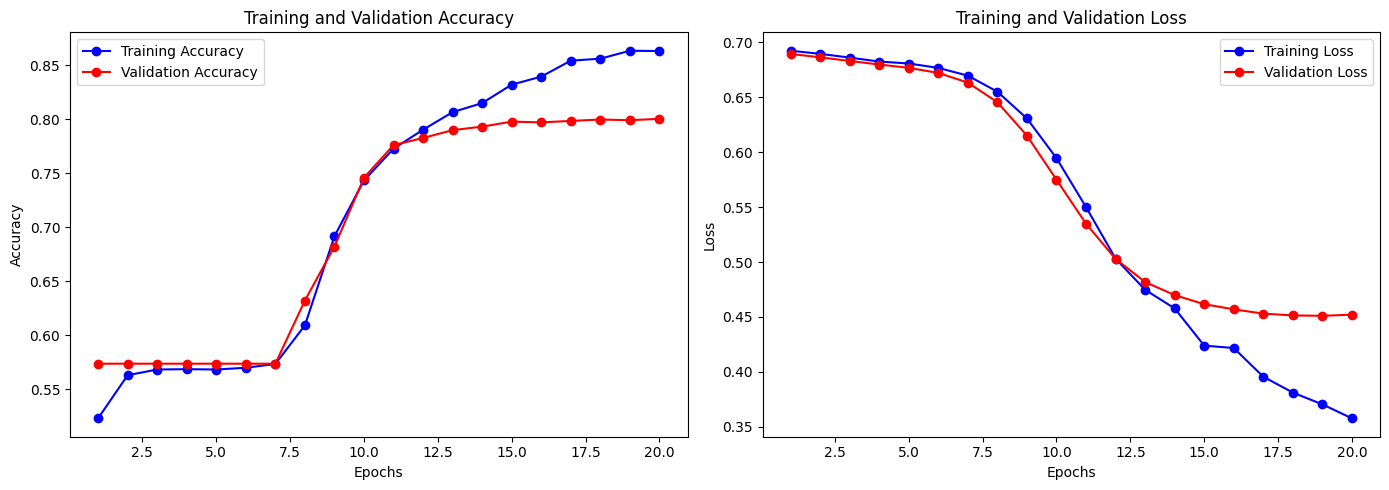

In [45]:
plot_training_history(history)

### Classification Report
We display precision, recall, and F1-score to analyze model performance across both classes. This helps understand how well the model detects disaster-related tweets.

In [47]:
val_preds = (model.predict(X_val_pad) > 0.5).astype("int32")
print(classification_report(y_val, val_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.65      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523




##  Submission
Create the submission CSV using the model's predictions on the test set.


In [ ]:
test_df["clean_text"] = test_df["text"].apply(clean_text)
submission_seq = tokenizer.texts_to_sequences(test_df["clean_text"])
submission_pad = pad_sequences(submission_seq, maxlen=max_len)
final_preds = (model.predict(submission_pad) > 0.5).astype("int32")

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": final_preds.flatten()
})
submission.to_csv("submission.csv", index=False)


## Summary & Conclusion

In this project, we tackled the Kaggle "Natural Language Processing with Disaster Tweets" binary classification challenge. Here's a recap of the key steps and takeaways:

### Key Steps:
- **Exploratory Data Analysis (EDA)** helped us understand the structure and balance of the dataset.
- **Text Cleaning** using regex and standard NLP techniques improved the quality of input data.
- **Tokenization and Padding** transformed the cleaned text into a format suitable for deep learning.
- We built and trained a **Bidirectional LSTM neural network**, which is effective for learning from sequential data like text.
- Model performance was evaluated using **accuracy**, **confusion matrix**, and **classification report** metrics.

### Observations:
- The dataset contains class imbalance, which slightly influenced performance.
- Bidirectional LSTMs helped capture the context of words in both directions, improving classification accuracy.
- Despite noise and missing metadata in tweets, the model learned to detect disaster-related content reasonably well.

### Future Improvements:
- Try more advanced architectures (e.g., GRU, Transformer-based models like BERT).
- Use pre-trained word embeddings (e.g., GloVe or Word2Vec).
- Address class imbalance using techniques like SMOTE or class weighting.
- Incorporate additional metadata (e.g., keyword, location) for better feature representation.

This mini-project demonstrates the power of NLP techniques and deep learning in solving real-world classification problems based on social media text.
